3.- Entrena un modelo en Keras con capas convolucionales para predecir el valor diario de cierre de bolsa de Amazon (puedes usar los datos que vimos en clase y que están en kaggle). Utiliza de los datos de apertura de 4 días anteriores para predecir el valor del día actual. Compáralo con un modelo con una capa lineal.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv1D, Flatten, GRU
from tensorflow.keras import regularizers

In [9]:
amazon = yf.Ticker("AMZN")
amzn_df = amazon.history(period="max")

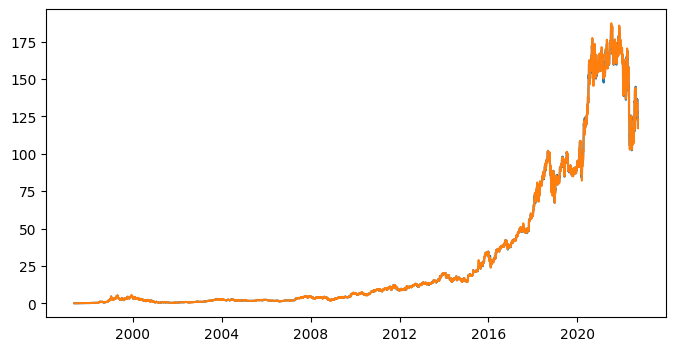

In [15]:
plt.figure(figsize=(8,4))
plt.plot(amzn_df.Close)
plt.plot(amzn_df.Open);


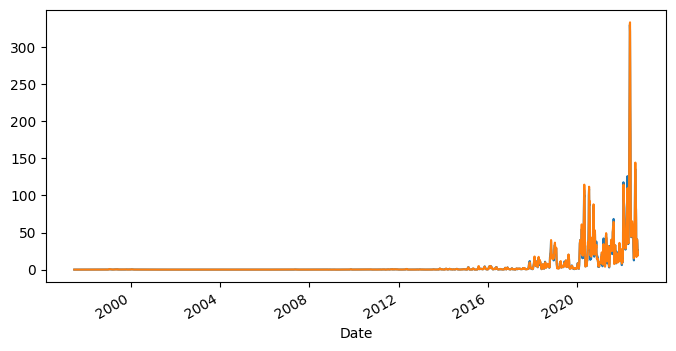

In [19]:
plt.figure(figsize=(8,4))
amzn_df.Close.rolling(window=22).var().plot()
amzn_df.Open.rolling(window=22).var().plot();

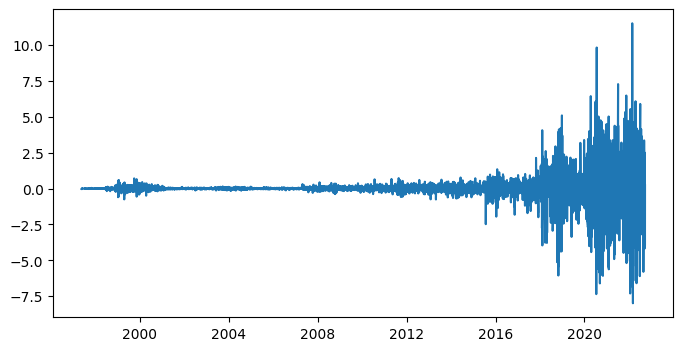

In [127]:
plt.figure(figsize=(8,4))
plt.plot(amzn_df.Close - amzn_df.Open);

In [20]:
batch_size = 4
n_valores = amzn_df.shape[0] -(amzn_df.shape[0]%batch_size)
X_train = amzn_df.iloc[:n_valores, :].Open.values.reshape(-1, batch_size, 1)
Y_train = amzn_df.iloc[:n_valores, :].Close.values[np.arange(3,n_valores,batch_size)]

In [21]:
X = amzn_df.iloc[:n_valores, :].Open.values.reshape(-1, batch_size, 1)
Y = amzn_df.iloc[:n_valores, :].Close.values[np.arange(3,n_valores,batch_size)]


1595

In [52]:
umbral = int(len(X)*0.9)
X_train, X_test = X[:umbral], X[umbral:]
Y_train, Y_test = Y[:umbral], Y[umbral:]

### Modelo Lineal

In [128]:
model_lineal = Sequential(model='lineal')
model_lineal.add(Flatten(input_shape=(4,1)))
model_lineal.add(Dense(1))
model_lineal.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 4)                 0         
                                                                 
 dense_39 (Dense)            (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [129]:
opt_adam = Adam(learning_rate = 5e-4)
model_lineal.compile(optimizer=opt_adam,
                   loss='mse',
                   metrics=['mae'])

In [ ]:
history = model_lineal.fit(X_train,
                        Y_train,
                        validation_split = 0.2,
                        epochs=1000,
                        batch_size=128)

In [ ]:
score = model_lineal.evaluate(X_test, Y_test)
score

5/5 [==============================] - 0s 3ms/step - loss: 6.9822 - mae: 2.1102


[6.982224464416504, 2.110225200653076]

### Modelo incluyendo capas Conv1D y Dense

In [131]:
model_amzn = Sequential(name='amzn_dense')

model_amzn.add(Conv1D(128, 2,
                      padding='same',
                      input_shape=(4,1),
                      activity_regularizer=regularizers.l2(0.01)))
model_amzn.add(Flatten())
model_amzn.add(Dense(124, activation='relu'))
model_amzn.add(Dense(64, activation='relu'))
model_amzn.add(Dense(1))

model_amzn.summary()

Model: "amzn_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 4, 128)            384       
                                                                 
 flatten_12 (Flatten)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 124)               63612     
                                                                 
 dense_43 (Dense)            (None, 64)                8000      
                                                                 
 dense_44 (Dense)            (None, 1)                 65        
                                                                 
Total params: 72,061
Trainable params: 72,061
Non-trainable params: 0
_________________________________________________________________


In [132]:
opt_adam = Adam(learning_rate = 5e-4)
model_amzn.compile(optimizer=opt_adam,
                   loss='mse',
                   metrics=['mae'])

In [133]:
history = model_amzn.fit(X_train,
                        Y_train,
                        validation_split = 0.2,
                        epochs=1000,
                        batch_size=64)

Epoch 1/1000
18/18 [==============================] - 1s 15ms/step - loss: 21.3389 - mae: 2.2591 - val_loss: 460.8008 - val_mae: 10.9659
Epoch 2/1000
18/18 [==============================] - 0s 8ms/step - loss: 4.8641 - mae: 0.5099 - val_loss: 314.7077 - val_mae: 3.5237
Epoch 3/1000
18/18 [==============================] - 0s 8ms/step - loss: 4.0373 - mae: 0.1803 - val_loss: 285.2652 - val_mae: 1.3180
Epoch 4/1000
18/18 [==============================] - 0s 8ms/step - loss: 3.7490 - mae: 0.1281 - val_loss: 267.8198 - val_mae: 0.9767
Epoch 5/1000
18/18 [==============================] - 0s 8ms/step - loss: 3.5022 - mae: 0.1231 - val_loss: 249.8826 - val_mae: 0.9339
Epoch 6/1000
18/18 [==============================] - 0s 9ms/step - loss: 3.2554 - mae: 0.1158 - val_loss: 231.6909 - val_mae: 0.9817
Epoch 7/1000
18/18 [==============================] - 0s 11ms/step - loss: 2.9987 - mae: 0.1176 - val_loss: 214.0355 - val_mae: 0.9819
Epoch 8/1000
18/18 [==============================] - 0s 8

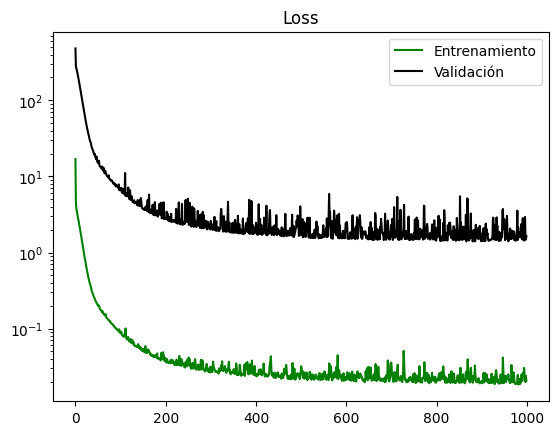

In [114]:
plt.title("Loss")
plt.plot(history.history['loss'],
         color='green',
         label="Entrenamiento")
plt.plot(history.history['val_loss'],
         color='black',
         label="Validación")
plt.legend()
plt.yscale("log")

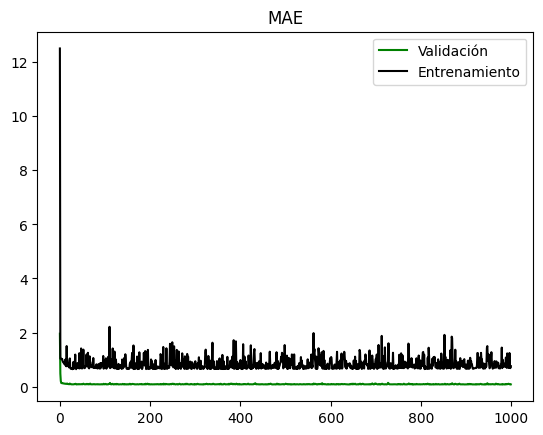

In [115]:
plt.title("MAE")
plt.plot(history.history['mae'],
         color='green',
         label="Validación")
plt.plot(history.history['val_mae'],
         color='black',
         label="Entrenamiento")
plt.legend()

In [116]:
score = model_amzn.evaluate(X_test, Y_test)
score

5/5 [==============================] - 0s 2ms/step - loss: 9.2615 - mae: 2.2546


[9.261514663696289, 2.254563808441162]

In [117]:
y_hat = model_amzn.predict(X_test)

5/5 [==============================] - 0s 2ms/step


In [122]:
type(list(y_hat))

list

In [125]:
plt.plot(y_hat)
plt.plot(Y_test)

SyntaxError: invalid syntax (176037393.py, line 2)